In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import cv2
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import glob
from keras.models import Model
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

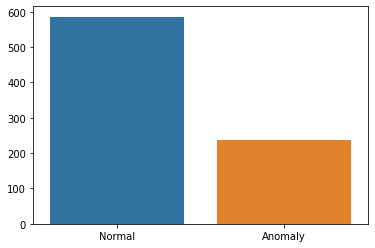

In [4]:
trainLabels = "/content/drive/MyDrive/diabeticRetinopathy/train/"
testLabels = "/content/drive/MyDrive/diabeticRetinopathy/test/"
valLabels = "/content/drive/MyDrive/diabeticRetinopathy/val/"

trainNormal = glob.glob(trainLabels+"normal/*.jpeg")
trainAnomaly = glob.glob(trainLabels+"anomaly/*.jpeg")
valNormal = glob.glob(valLabels+"normal/*.jpeg")
valAnomaly = glob.glob(valLabels+"anomaly/*.jpeg")
testNormal = glob.glob(testLabels+"normal/*.jpeg")
testAnomaly = glob.glob(testLabels+"anomaly/*.jpeg")

sns.barplot(x=["Normal","Anomaly"],y=[len(trainNormal),len(trainAnomaly)])

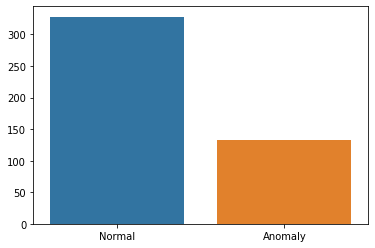

In [5]:
sns.barplot(x=["Normal","Anomaly"],y=[len(valNormal),len(valAnomaly)])

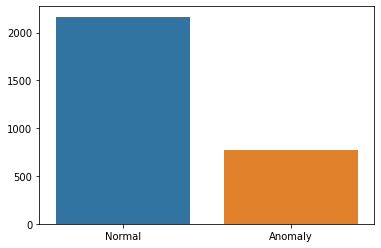

In [6]:
sns.barplot(x=["Normal","Anomaly"],y=[len(testNormal),len(testAnomaly)])

In [7]:
print('Anomaly images in training set = ', len(trainAnomaly))
print('Normal images in training set = ', len(trainNormal))
print('Anomaly images in validation set = ', len(valAnomaly))
print('Normal images in validation set = ', len(valNormal))
print('Anomaly images in testing set = ', len(testAnomaly))
print('Normal images in testing set = ', len(testNormal))

Anomaly images in training set =  238
Normal images in training set =  586
Anomaly images in validation set =  133
Normal images in validation set =  328
Anomaly images in testing set =  772
Normal images in testing set =  2166


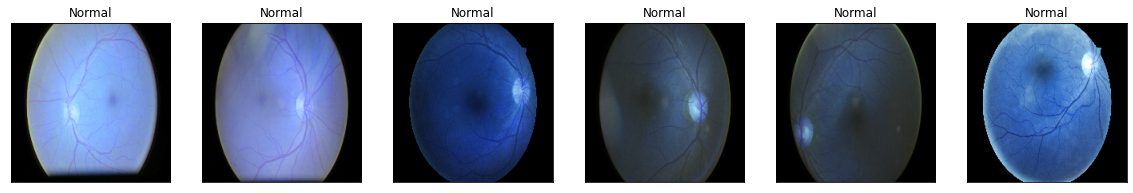

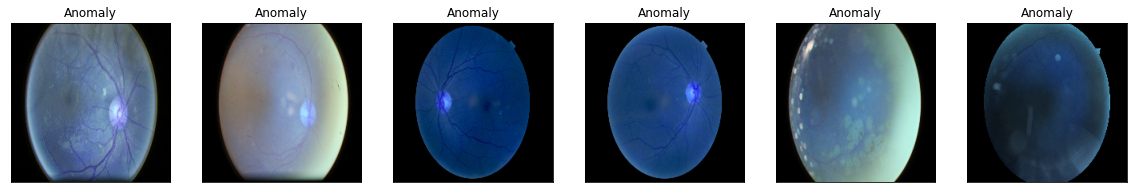

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainNormal[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.set_title("Normal")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,20), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(trainAnomaly[i])
    img = cv2.resize(img, (200,200))
    ax.imshow(img)
    ax.set_title("Anomaly")
plt.show()

In [9]:
training = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
validation = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
testing = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [10]:
training_dataset = training.flow_from_directory(trainLabels,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')
validation_dataset = validation.flow_from_directory(valLabels,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')
testing_dataset = testing.flow_from_directory(testLabels,
                                            target_size = (224,224), 
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 824 images belonging to 2 classes.
Found 461 images belonging to 2 classes.
Found 2938 images belonging to 2 classes.


In [11]:
testing_dataset.class_indices


{'anomaly': 0, 'normal': 1}

In [ ]:
efficientNet = tf.keras.applications.EfficientNetB0(weights = None, include_top = False, input_shape = (224,224,3), classes = 2)
lastLayer = efficientNet.get_layer('top_activation')
X = lastLayer.output
X = tf.keras.layers.Flatten()(X)
# X = tf.keras.layers.Dropout(0.5)(X)

X = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model1 = tf.keras.Model(efficientNet.input, X)
model1.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model1.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_17 (Rescaling)       (None, 224, 224, 3)  0           ['input_18[0][0]']               
                                                                                                  
 normalization_17 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_17[0][0]']           
 n)                                                                                               
                                                                                           

In [ ]:
history1 = model1.fit(training_dataset, validation_data = validation_dataset, epochs = 50)

Epoch 1/50
52/52 [==============================] - 151s 3s/step - loss: 0.7327 - accuracy: 0.6517 - val_loss: 0.6332 - val_accuracy: 0.7115
Epoch 2/50
52/52 [==============================] - 139s 3s/step - loss: 0.6217 - accuracy: 0.7172 - val_loss: 0.6199 - val_accuracy: 0.7115
Epoch 3/50
52/52 [==============================] - 138s 3s/step - loss: 0.5655 - accuracy: 0.7330 - val_loss: 0.6009 - val_accuracy: 0.7115
Epoch 4/50
52/52 [==============================] - 138s 3s/step - loss: 0.5406 - accuracy: 0.7403 - val_loss: 0.6220 - val_accuracy: 0.7115
Epoch 5/50
52/52 [==============================] - 138s 3s/step - loss: 0.4955 - accuracy: 0.7828 - val_loss: 0.6053 - val_accuracy: 0.7115
Epoch 6/50
52/52 [==============================] - 138s 3s/step - loss: 0.4666 - accuracy: 0.7973 - val_loss: 0.6052 - val_accuracy: 0.7115
Epoch 7/50
52/52 [==============================] - 138s 3s/step - loss: 0.4273 - accuracy: 0.8143 - val_loss: 0.6048 - val_accuracy: 0.7115
Epoch 8/50
52

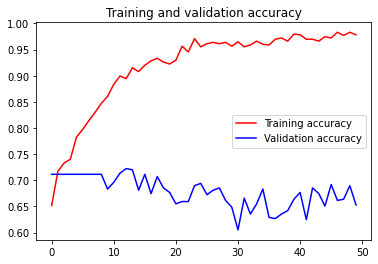

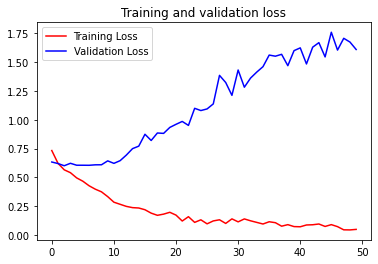

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model1.evaluate(testing_dataset)

184/184 [==============================] - 1420s 8s/step - loss: 1.6819 - accuracy: 0.6188


[1.6818915605545044, 0.6187883019447327]

In [15]:
model2 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16,(3,3),activation = 'relu', input_shape = (224,224,3)),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Conv2D(256,(3,3),activation = 'relu'),
                                   tf.keras.layers.BatchNormalization(),
                                   tf.keras.layers.MaxPool2D(2,2),
                                   #
                                   tf.keras.layers.Flatten(),
                                   ##
                                   tf.keras.layers.Dense(512,activation = 'relu'),
                                   ##
                                   tf.keras.layers.Dropout(0.5),
                                     
                                   tf.keras.layers.Dense(1,activation = 'sigmoid'),
                                   ])
model2.compile(loss = 'binary_crossentropy', 
             optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_6 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                      

In [16]:
history2 = model2.fit(training_dataset, validation_data = validation_dataset, epochs = 50)

Epoch 1/50
52/52 [==============================] - 143s 3s/step - loss: 1.2625 - accuracy: 0.6129 - val_loss: 0.6868 - val_accuracy: 0.5358
Epoch 2/50
52/52 [==============================] - 140s 3s/step - loss: 0.8220 - accuracy: 0.6553 - val_loss: 0.6200 - val_accuracy: 0.6855
Epoch 3/50
52/52 [==============================] - 140s 3s/step - loss: 0.6904 - accuracy: 0.7172 - val_loss: 0.5941 - val_accuracy: 0.7137
Epoch 4/50
52/52 [==============================] - 139s 3s/step - loss: 0.5907 - accuracy: 0.7415 - val_loss: 0.6389 - val_accuracy: 0.7072
Epoch 5/50
52/52 [==============================] - 140s 3s/step - loss: 0.5538 - accuracy: 0.7646 - val_loss: 0.6242 - val_accuracy: 0.7028
Epoch 6/50
52/52 [==============================] - 138s 3s/step - loss: 0.5234 - accuracy: 0.7731 - val_loss: 0.6628 - val_accuracy: 0.7093
Epoch 7/50
52/52 [==============================] - 139s 3s/step - loss: 0.4466 - accuracy: 0.7864 - val_loss: 0.6901 - val_accuracy: 0.6876
Epoch 8/50
52

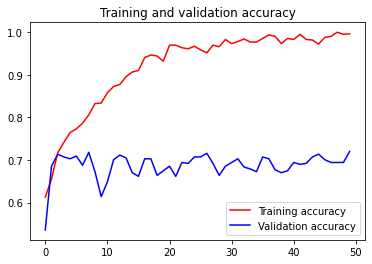

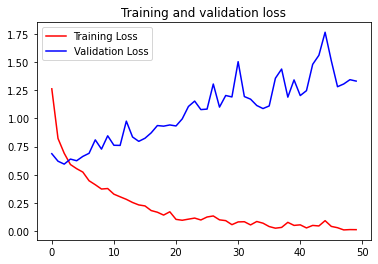

In [17]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
model2.evaluate(testing_dataset)

184/184 [==============================] - 3069s 17s/step - loss: 1.4445 - accuracy: 0.6801


[1.4445236921310425, 0.6800544857978821]